In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC/Base_Files/full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
48376,NaN,NaN,International,2020-10-04,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48377,NaN,NaN,International,2020-10-05,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48378,NaN,NaN,International,2020-10-06,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


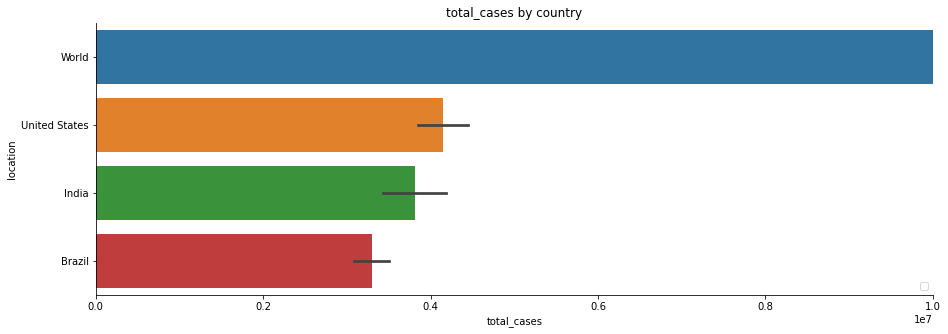

In [13]:
worldrep("total_cases",graph_long=5,val_larg=10000000)

No handles with labels found to put in legend.


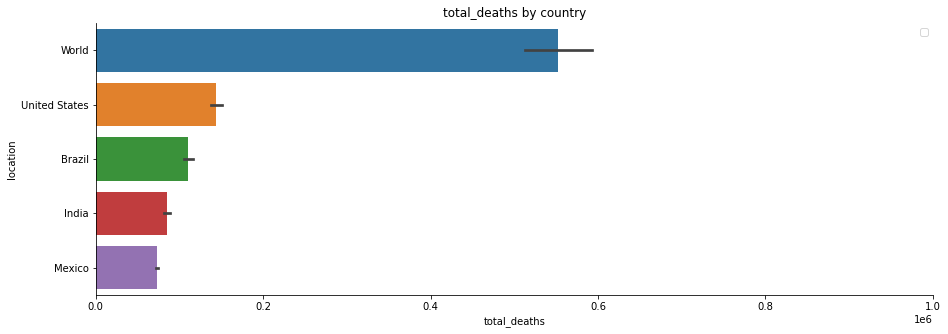

In [14]:
worldrep("total_deaths",val_larg=1000000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


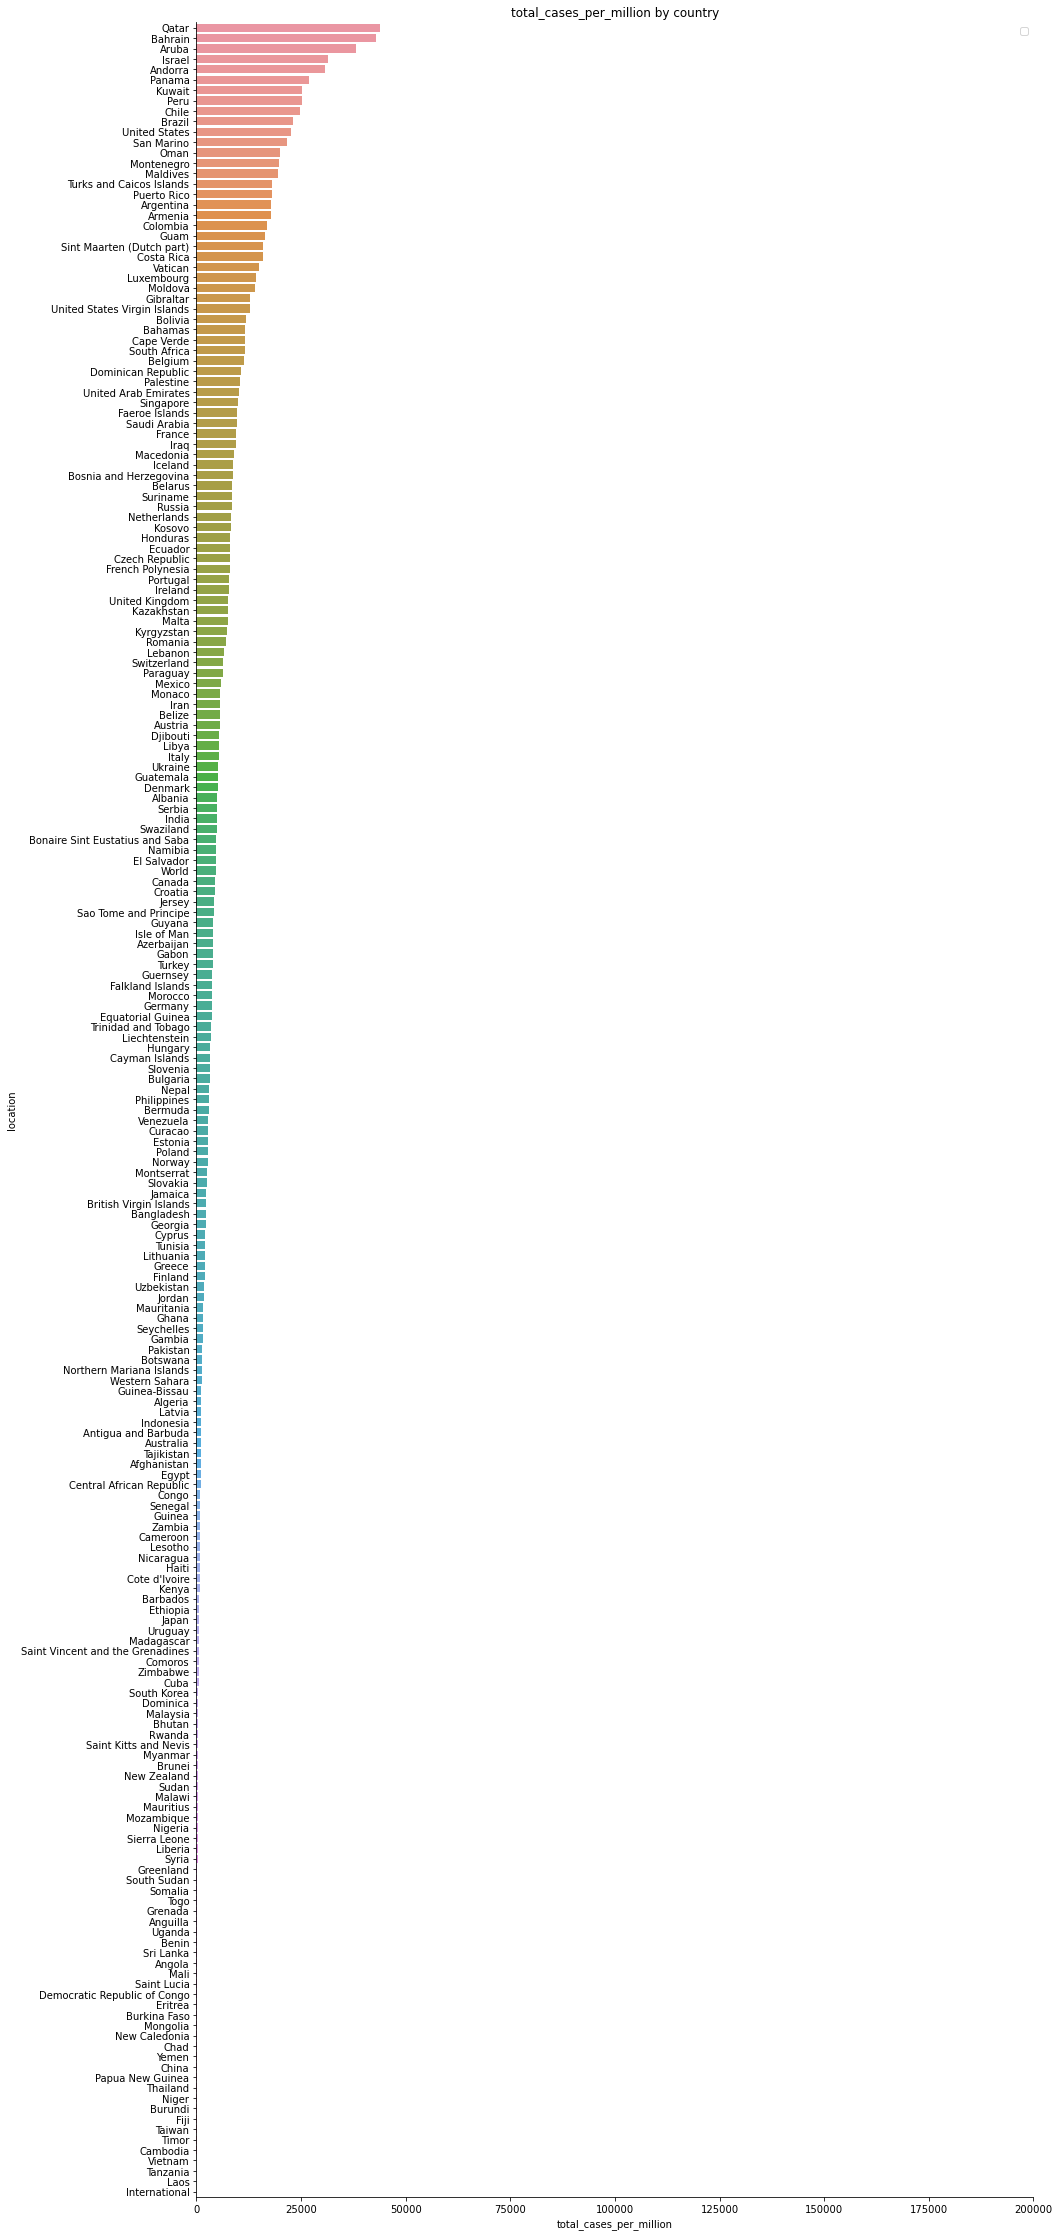

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=200000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


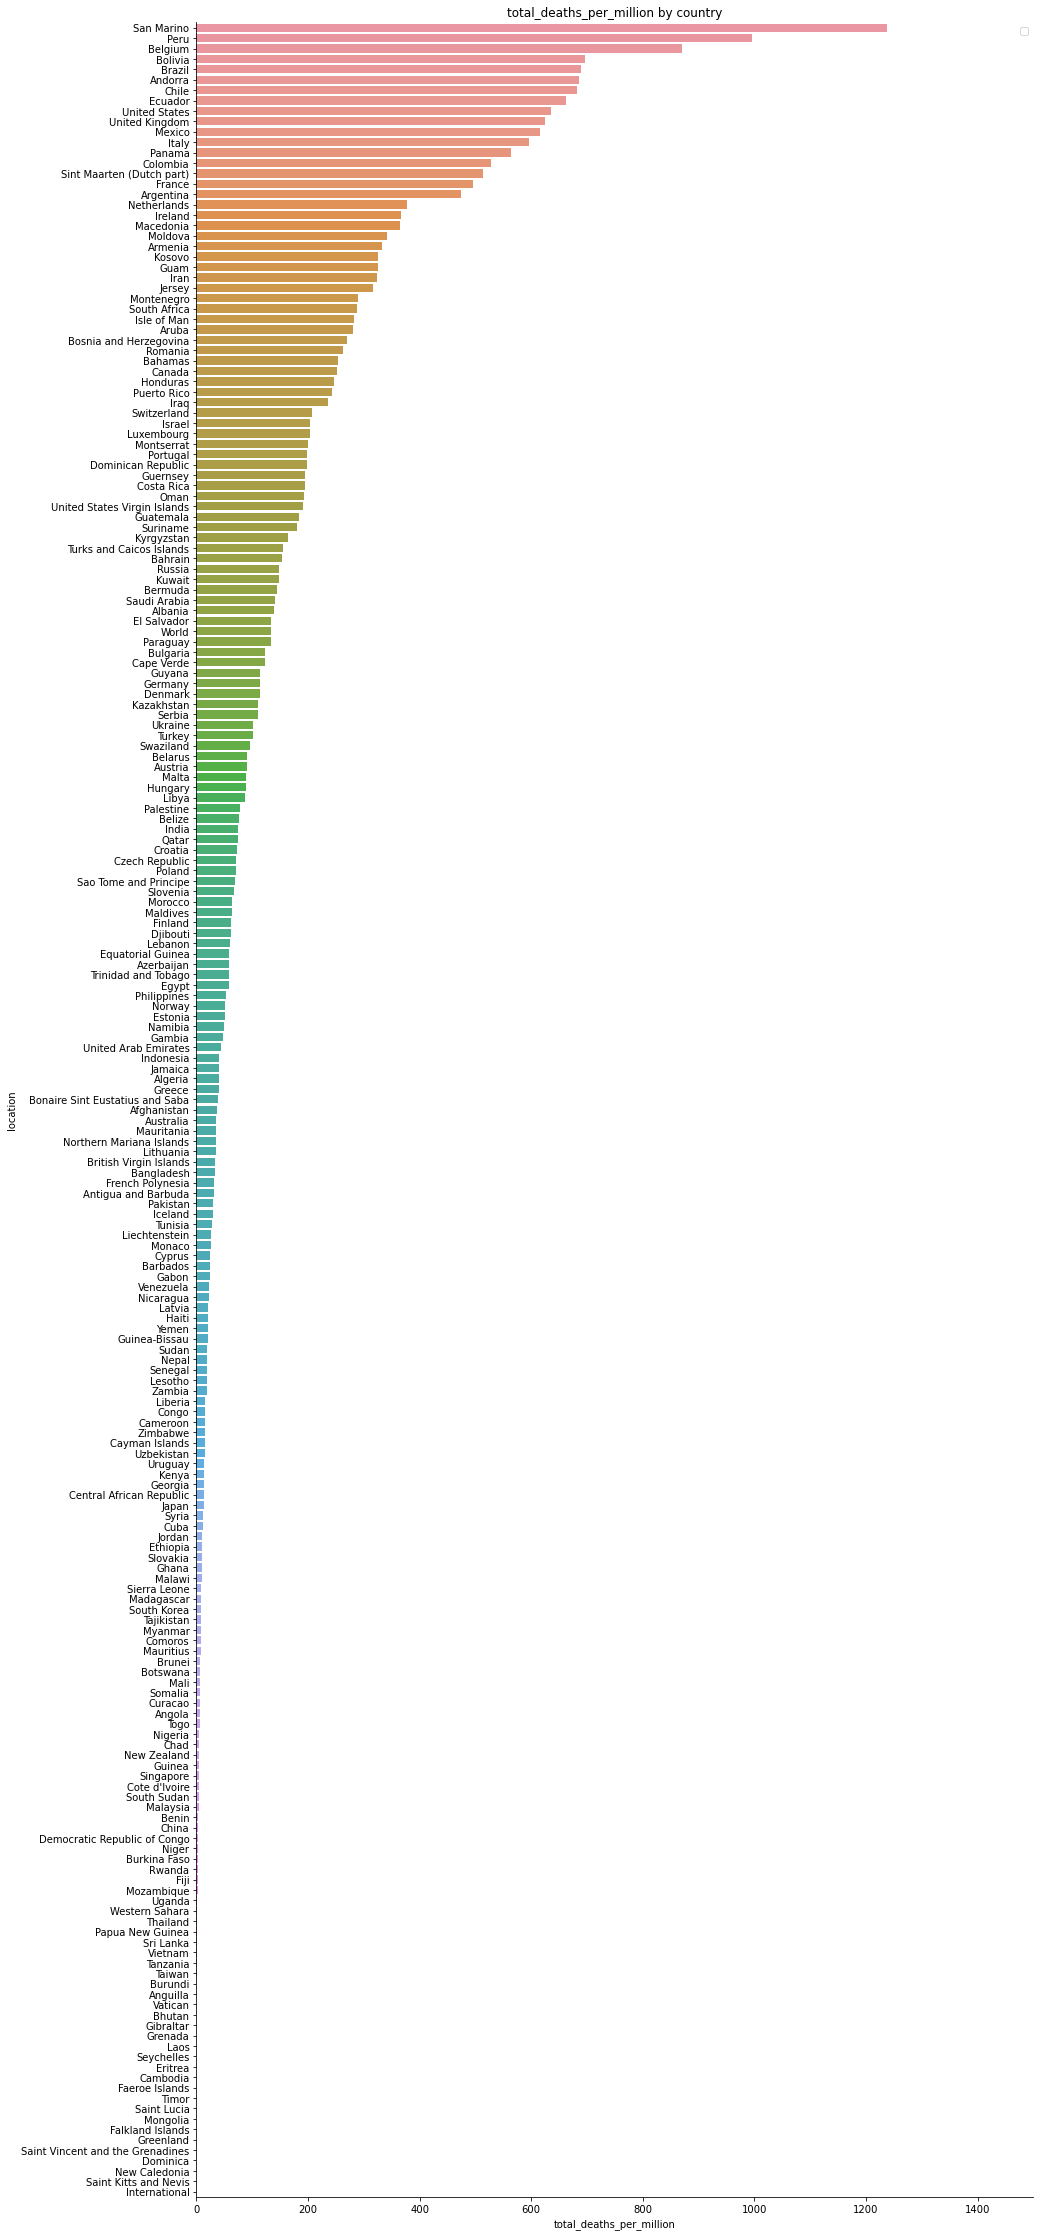

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

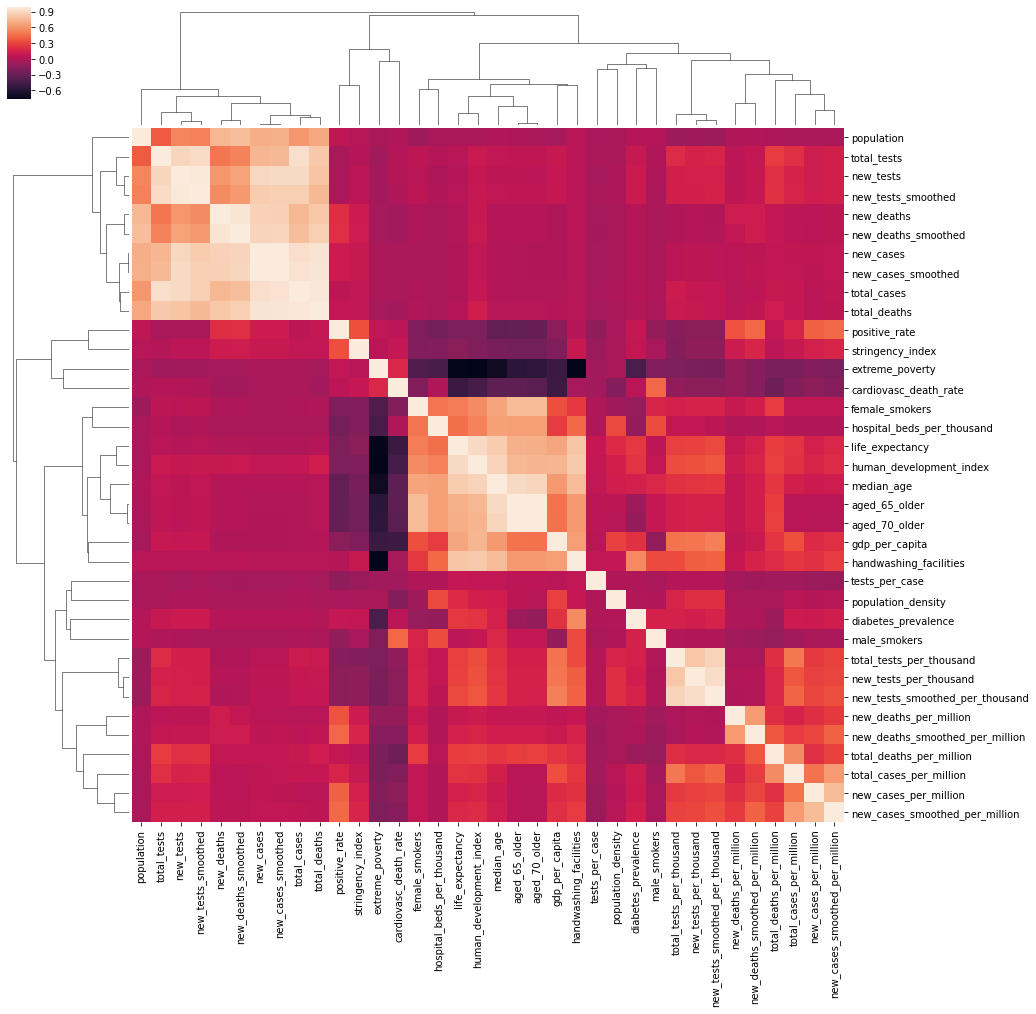

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9968967292923022 (+/- 0.004257248327329587)
Coef :  [1.02886847e+00 7.38675844e-05 7.62030640e-05]
3 Last_days :  [[34990354 35272552 35523518]]
Today :  35523518
Prediction + :  598771
Tomorow :  36122289
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995208746673504 (+/- 0.00024725923663426427)
Coef :  [0.30458245 0.34221314 0.36293504]
3 Last_days :  [[1034256 1038219 1042398]]
Today :  1042398
Prediction + :  9968
Tomorow :  1052366
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8375121168177274 (+/- 0.22564237850012125)
Coef :  [-0.63188117  0.70249321  0.9378819 ]
3 Last_days :  [[606625 619170 624274]]
Today :  624274
Prediction + :  12681
Tomorow :  636955
                                     
--------- Total Death -----------------
                                     
R^2: 0.7366223718704372 (+/- 0.36639354079809905)
Coef :  [-0.74154874  0.78637733  0.95412449]
3 Last_days :  [[32198 32230 32299]]
Today :  32299
Prediction + :  41
Tomorow :  32340
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9762981406522325 (+/- 0.02897145996621602)
Coef :  [-0.33283296 -0.00513179  1.33223079]
3 Last_days :  [[90604 90629 90652]]
Today :  90652
Prediction + :  23
Tomorow :  90675
                                     
--------- Total Death -----------------
                                     
R^2: -4.933141985614003 (+/- 8.277666455535453)
Coef :  [-0.07798387  0.01251013  1.05707295]
3 Last_days :  [[4739 4739 4739]]
Today :  4739
Prediction + :  5
Tomorow :  4744
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8656817740408088 (+/- 0.18862210960196832)
Coef :  [-0.80119417  0.88705819  0.91382335]
3 Last_days :  [[322751 325329 327586]]
Today :  327586
Prediction + :  2169
Tomorow :  329755
                                     
--------- Total Death -----------------
                                     
R^2: 0.6261397204200426 (+/- 0.5142332565709249)
Coef :  [-0.81454596  0.89276997  0.92071763]
3 Last_days :  [[35968 35986 36002]]
Today :  36002
Prediction + :  32
Tomorow :  36034
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: -3.533117531709175 (+/- 6.3985207043372485)
Coef :  [-0.19559212  0.17326477  1.03268903]
3 Last_days :  [[789932 789932 813412]]
Today :  813412
Prediction + :  8971
Tomorow :  822383
                                     
--------- Total Death -----------------
                                     
R^2: -0.8482198602546788 (+/- 2.3413287104099885)
Coef :  [-0.73159906  0.65173791  1.07892501]
3 Last_days :  [[32086 32086 32225]]
Today :  32225
Prediction + :  20
Tomorow :  32245
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.905136486768412 (+/- 0.12902299750729898)
Coef :  [0.22529281 0.38998232 0.39685365]
3 Last_days :  [[7382944 7417845 7458550]]
Today :  7458550
Prediction + :  78998
Tomorow :  7537548
                                     
--------- Total Death -----------------
                                     
R^2: 0.9707720819027649 (+/- 0.04003156370809626)
Coef :  [-0.31446118  0.63055461  0.68659968]
3 Last_days :  [[209394 209794 210192]]
Today :  210192
Prediction + :  1096
Tomorow :  211288
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9645769503986971 (+/- 0.04750435428971216)
Coef :  [-0.80361222  0.79826399  1.00745443]
3 Last_days :  [[480017 502978 515571]]
Today :  515571
Prediction + :  19677
Tomorow :  535248
                                     
--------- Total Death -----------------
                                     
R^2: 0.9398944437336584 (+/- 0.0692011001576848)
Coef :  [-0.7584037   0.82804563  0.92954266]
3 Last_days :  [[42317 42350 42369]]
Today :  42369
Prediction + :  56
Tomorow :  42425
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7716042601132723 (+/- 0.32215678893315863)
Coef :  [-0.7599921   0.8421282   0.91811739]
3 Last_days :  [[299237 300619 303258]]
Today :  303258
Prediction + :  1237
Tomorow :  304495
                                     
--------- Total Death -----------------
                                     
R^2: 0.12175144985080662 (+/- 1.2358836785772895)
Coef :  [-0.77799724  0.8368415   0.94030983]
3 Last_days :  [[9529 9534 9546]]
Today :  9546
Prediction + :  9
Tomorow :  9555
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9971593775510076 (+/- 0.002709566673687151)
Coef :  [0.45087728 0.28286987 0.27851789]
3 Last_days :  [[468119 471772 475674]]
Today :  475674
Prediction + :  3037
Tomorow :  478711
                                     
--------- Total Death -----------------
                                     
R^2: 0.905508466660307 (+/- 0.1324707400286597)
Coef :  [0.28788874 0.36857693 0.35562962]
3 Last_days :  [[26746 26957 27192]]
Today :  27192
Prediction + :  193
Tomorow :  27385
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996473150112614 (+/- 0.0002697089441969254)
Coef :  [-0.5339821   0.75488089  0.77641401]
3 Last_days :  [[323014 324443 326046]]
Today :  326046
Prediction + :  1120
Tomorow :  327166
                                     
--------- Total Death -----------------
                                     
R^2: 0.9992934077944499 (+/- 0.0006621619455608441)
Coef :  [-0.81009173  0.89608175  0.91278686]
3 Last_days :  [[8384 8441 8498]]
Today :  8498
Prediction + :  48
Tomorow :  8546
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8391916244359535 (+/- 0.22055867454611117)
Coef :  [-0.0863789   0.49921665  0.59762162]
3 Last_days :  [[4906833 4915289 4927235]]
Today :  4927235
Prediction + :  57500
Tomorow :  4984735
                                     
--------- Total Death -----------------
                                     
R^2: 0.43908757794744374 (+/- 0.7860044074443769)
Coef :  [0.02191942 0.46296429 0.5242639 ]
3 Last_days :  [[145987 146352 146675]]
Today :  146675
Prediction + :  1568
Tomorow :  148243
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(35523518, 1042398, 36122289, 1052366),
 (624274, 32299, 636955, 32340),
 (327586, 36002, 329755, 36034),
 (813412, 32225, 822383, 32245),
 (7458550, 210192, 7537548, 211288),
 (90652, 4739, 90675, 4744),
 (515571, 42369, 535248, 42425),
 (303258, 9546, 304495, 9555),
 (475674, 27192, 478711, 27385),
 (326046, 8498, 327166, 8546),
 (4927235, 146675, 4984735, 148243)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-10-06,France,636955.0,0.0,32340.0,0.0,0.0,0.0
0,2020-10-06,China,90675.0,0.0,4744.0,0.0,0.0,0.0
0,2020-10-06,Italy,329755.0,0.0,36034.0,0.0,0.0,0.0
0,2020-10-06,Spain,822383.0,0.0,32245.0,0.0,0.0,0.0
0,2020-10-06,United States,7537548.0,0.0,211288.0,0.0,0.0,0.0
0,2020-10-06,World,36122289.0,0.0,1052366.0,0.0,0.0,0.0
0,2020-10-06,United Kingdom,535248.0,0.0,42425.0,0.0,0.0,0.0
0,2020-10-06,Germany,304495.0,0.0,9555.0,0.0,0.0,0.0
0,2020-10-06,Iran,478711.0,0.0,27385.0,0.0,0.0,0.0
0,2020-10-06,Turkey,327166.0,0.0,8546.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")